In [1]:
# %matplotlib qt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import mne
from mne.channels import find_ch_adjacency
from mne.stats import bonferroni_correction, fdr_correction
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test

from utils import bad_participant


Using MNE with API > 0.19


In [2]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'


all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']


# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac
bad_participants = []
for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 

    if bad_participant(epochs, probe= 'PC', mind = 'mind2'):
        bad_participants.append(participant)

print('List of bad participants: ', bad_participants)

good_participants = [x for x in all_participants if x not in bad_participants]
print(f'{len(good_participants)} good participants remaining')

List of bad participants:  ['VP08', 'VP09', 'VP12', 'VP14', 'VP19', 'VP20', 'VP23', 'VP25', 'VP29', 'VP30', 'VP31', 'VP32', 'VP33']
13 good participants remaining


In [3]:
channels = ['FC1', 'FCz', 'FC2', 'C1', 'Cz','C2', 'CP1', 'CPz', 'CP2']
# channels = ['Cz']
idx =  [epochs.ch_names.index(channel) for channel in channels]

In [17]:
evoked_mw = []
evoked_ot = []

prev_trial = 5

def try_except(epochs,string):
    try:
        return epochs[string]
    except:
        pass
    

for i in good_participants:
    participant = i

    folder = path + participant +'/'
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_subtracted_epo.fif', verbose = False) 
    epochs.info['description'] = 'biosemi/64' #necessary for wSMI x
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    
    ot_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/on-task/correct/go/{i}')for i in range(1,prev_trial)])
    evoked_ot.append(ot_epochs.average().data)
    try:
        smw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/sMW/correct/go/{i}')for i in range(1,prev_trial)])
        dmw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/dMW/correct/go/{i}')for i in range(1,prev_trial)])
        evoked_mw.append(mne.concatenate_epochs([smw_epochs, dmw_epochs]).average().data)
    except:
        try:
#             dmw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/dMW/correct/go/{i}')for i in range(1,prev_trial)])
            evoked_mw.append(dmw_epochs.average().data)
        except:
            try:
                smw_epochs = mne.concatenate_epochs([try_except(epochs,f'PC/sMW/correct/go/{i}')for i in range(1,prev_trial)])
                evoked_mw.append(smw_epochs.average().data)
            except:
                pass
        
evoked_mw = np.array(evoked_mw)[:,idx,:]
evoked_ot = np.array(evoked_ot)[:,idx,:]
# evoked_mw = np.array(evoked_mw)
# evoked_ot = np.array(evoked_ot)

TypeError: epochs_list[0] must be an instance of Epochs, got <class 'NoneType'>

In [18]:
ot_grand_average = np.mean(evoked_ot, axis = 1)
mw_grand_average = np.mean(evoked_mw, axis = 1)

contrasts = [ ot_grand_average,mw_grand_average]

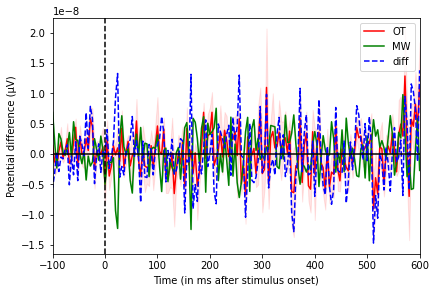

In [19]:
tmax = 0.6
scale = 1e6

diff = (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale)
# diff_std =  stats.sem(contrasts[0] - contrasts[1]) * scale

fig, ax = plt.subplots(1)


ax.plot(epochs.times * 1000, np.mean(contrasts[0],axis = 0) * scale,
        'r', label='OT')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[0],axis = 0) - stats.sem(contrasts[0],axis = 0)) * scale,  
                 (np.mean(contrasts[0],axis = 0) + stats.sem(contrasts[0],axis = 0)) * scale, color = 'r', alpha= 0.1)
ax.plot(epochs.times * 1000, np.mean(contrasts[1],axis = 0) * scale,
        'g', label='MW')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[1],axis = 0) - stats.sem(contrasts[1],axis = 0)) * scale,  
                 (np.mean(contrasts[1],axis = 0) + stats.sem(contrasts[1],axis = 0)) * scale, color = 'g',alpha = 0.1)
ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
        'b', label='diff', ls = '--')
# plt.fill_between(epochs.times * 1000, diff-diff_std, diff+diff_std , color = 'b',alpha = 0.1)

# ax.grid(True)
ax.set(xlim=[-100, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#        ylim=[-12.5, 5],
       ylabel=u'Potential difference (μV)')
ax.axvline(0, ls='--', color='k')
ax.axhline(0, ls='-', color='k')

plt.legend()

fig.tight_layout(pad=0.5)


plt.savefig('Figs/ero_ot_vs_mw.png')
plt.show()

In [ ]:
for i in range(12):

    scale = 1e6

    plt.plot(epochs.times * 1000, contrasts[0][i] * scale-contrasts[1][i] * scale,
            'b', label='diff')

#     ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
#             'b', label='diff')

plt.grid(True)
# plt.set(xlim=[-100, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#     #        ylim=[-12.5, 5],
#         ylabel=u'Potential difference (μV)')

# plt.legend()

plt.tight_layout(pad=0.5)

plt.show()

In [ ]:
T, pval = stats.ttest_rel(contrasts[0],contrasts[1], axis  =0)
alpha = 0.05

n_tests,  n_samples= np.array(contrasts[0]).shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
threshold_fdr = np.min(np.abs(T)[reject_fdr])

In [ ]:
times = 1e3 * epochs.times

plt.close('all')
plt.plot(times, T, 'k', label='T-stat')
xmin, xmax = plt.xlim()
plt.hlines(threshold_uncorrected, xmin, xmax, linestyle='--', colors='k',
           label='p=0.05 (uncorrected)', linewidth=2)
plt.hlines(threshold_bonferroni, xmin, xmax, linestyle='--', colors='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
plt.hlines(threshold_fdr, xmin, xmax, linestyle='--', colors='b',
           label='p=0.05 (FDR)', linewidth=2)
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("T-stat")
plt.show()

In [ ]:
n_permutations = 1000
T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=1)

In [ ]:
data = [evoked_ot, evoked_mw]
adjacency, _ = find_ch_adjacency(epochs.info, "eeg")
n_permutations = 1000  # number of permutations to run

# set initial threshold
p_initial = 0.001

# set family-wise p-value
p_thresh = 0.5

connectivity = None

# set cluster threshold
n_samples = len(data)
# threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
# threshold = 6


cluster_stats = permutation_cluster_test(
    data,  verbose=True, tail=0,
#     adjacency =adjacency,
    n_permutations=n_permutations, seed=42)

T_obs, clusters, cluster_p_values, _ = cluster_stats

In [ ]:
cluster_p_values

# dMW vs sMW

In [12]:
epoch_type = 'evoked'
# epoch_type = 'pseudo-rs'


all_participants = ['VP07','VP08','VP09', 'VP10','VP11','VP12','VP13','VP14','VP18','VP19','VP20','VP22','VP23','VP24','VP25','VP26','VP27','VP28','VP29','VP30','VP31','VP32','VP33','VP35','VP36','VP37']


# path = '/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/' #icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac
bad_participants = []
for i in all_participants:
    participant = i
    
    folder = path + participant +'/'
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 

    if bad_participant(epochs, probe= 'SC', mind = 'mind'):
        bad_participants.append(participant)

print('List of bad participants: ', bad_participants)

good_participants = [x for x in all_participants if x not in bad_participants]
print(f'{len(good_participants)} good participants remaining')

List of bad participants:  ['VP07', 'VP10', 'VP11', 'VP12', 'VP22', 'VP23', 'VP27', 'VP28', 'VP32', 'VP36']
16 good participants remaining


In [13]:
evoked_dmw = []
evoked_smw = []

prev_trial = 5

def try_except(epochs,string):
    try:
        return epochs[string]
    except:
        pass
    

for i in good_participants:
    participant = i

    folder = path + participant +'/'
    
    #############################
    #### With ERP SUBTRACTED ####
    #############################
    epochs = mne.read_epochs(folder +  participant + '_' + epoch_type + '_' +  'ar_rereferenced_epo.fif', verbose = False) 
    epochs.info['description'] = 'biosemi/64' #necessary for wSMI x
    epochs =  epochs.pick_types(eeg = True) #EOGs break everything\
    
    
    try:
        dmw_epochs = epochs['SC/dMW/correct/go']
        evoked_dmw.append(dmw_epochs.average().data)
    except:
        pass
    
    try:
        smw_epochs = epochs['SC/sMW/correct/go']
        evoked_smw.append(smw_epochs.average().data)
    except:
        pass

        
evoked_dmw = np.array(evoked_dmw)[:,idx,:]
evoked_smw = np.array(evoked_smw)[:,idx,:]
# evoked_mw = np.array(evoked_mw)
# evoked_ot = np.array(evoked_ot)

In [14]:
dmw_grand_average = np.mean(evoked_dmw, axis = 1)
smw_grand_average = np.mean(evoked_smw, axis = 1)

contrasts = [ dmw_grand_average, smw_grand_average]

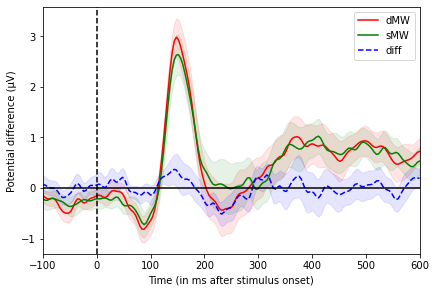

In [16]:
tmax = 0.6
diff = (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale)
diff_std =  stats.sem(contrasts[0] - contrasts[1]) * scale

fig, ax = plt.subplots(1)
scale = 1e6

ax.plot(epochs.times * 1000, np.mean(contrasts[0],axis = 0) * scale,
        'r', label='dMW')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[0],axis = 0) - stats.sem(contrasts[0],axis = 0)) * scale,  
                 (np.mean(contrasts[0],axis = 0) + stats.sem(contrasts[0],axis = 0)) * scale, color = 'r', alpha= 0.1)
ax.plot(epochs.times * 1000, np.mean(contrasts[1],axis = 0) * scale,
        'g', label='sMW')
plt.fill_between(epochs.times * 1000, (np.mean(contrasts[1],axis = 0) - stats.sem(contrasts[1],axis = 0)) * scale,  
                 (np.mean(contrasts[1],axis = 0) + stats.sem(contrasts[1],axis = 0)) * scale, color = 'g',alpha = 0.1)
ax.plot(epochs.times* 1000, (np.mean(contrasts[0],axis = 0) * scale - np.mean(contrasts[1],axis = 0) * scale),
        'b', label='diff', ls = '--')
plt.fill_between(epochs.times * 1000, diff-diff_std, diff+diff_std , color = 'b',alpha = 0.1)

# ax.grid(True)
ax.set(xlim=[-100, 1000 * tmax], xlabel='Time (in ms after stimulus onset)',
#        ylim=[-12.5, 5],
       ylabel=u'Potential difference (μV)')
ax.axvline(0, ls='--', color='k')
ax.axhline(0, ls='-', color='k')

plt.legend()

fig.tight_layout(pad=0.5)

plt.savefig('Figs/erp_dmw_vs_smw.png')
plt.show()